In [8]:
import zipfile
import os

# Path to the uploaded zip file in Colab's temporary storage
zip_file_path = '/content/KWS.zip'
# Directory where you want to extract the contents
extract_to_path = '/content/' # Or '/content/sample_data/' if you put it there

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_to_path):
    os.makedirs(extract_to_path)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Files extracted to {extract_to_path}")
# You can then verify by listing the contents
kws_folder_path = os.path.join(extract_to_path, 'KWS')
if os.path.exists(kws_folder_path):
    print(f"KWS folder found at: {kws_folder_path}")
    print("Contents:", os.listdir(kws_folder_path))
else:
    print(f"KWS folder NOT found at: {kws_folder_path}")

# Update your data paths accordingly
KWS_DATA_PATH = kws_folder_path
IMAGES_PATH = os.path.join(KWS_DATA_PATH, 'images')
LOCATIONS_PATH = os.path.join(KWS_DATA_PATH, 'locations')
KEYWORDS_FILE = os.path.join(KWS_DATA_PATH, 'keywords.tsv')
TRANSCRIPTION_FILE = os.path.join(KWS_DATA_PATH, 'transcription.tsv')
TRAIN_FILE = os.path.join(KWS_DATA_PATH, 'train.tsv')
VALIDATION_FILE = os.path.join(KWS_DATA_PATH, 'validation.tsv')

Files extracted to /content/
KWS folder found at: /content/KWS
Contents: ['train.tsv', 'locations', 'keywords.tsv', 'validation.tsv', 'transcription.tsv', 'task', 'images']


In [9]:
# --------------------------------------
# Cell 1: Setup and Configuration
# --------------------------------------

# 1. Import necessary libraries
import os
import cv2 # OpenCV for image processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET # For parsing SVG (standard library)
# from lxml import etree # Alternative, more robust XML parser if you installed it.
from PIL import Image # Pillow, often used for image I/O and manipulation

# Potentially useful for later, but not strictly for setup:
# from sklearn.model_selection import train_test_split # If we needed to make our own splits
# import tensorflow as tf # If using TensorFlow for the model
# import torch # If using PyTorch for the model

# 2. Define data paths (confirming paths from your previous successful output)
# Base path to the KWS data within Colab's temporary storage
KWS_DATA_PATH = '/content/KWS/'

# Specific paths to subdirectories and key files
IMAGES_PATH = os.path.join(KWS_DATA_PATH, 'images')
LOCATIONS_PATH = os.path.join(KWS_DATA_PATH, 'locations')
KEYWORDS_FILE = os.path.join(KWS_DATA_PATH, 'keywords.tsv')
TRANSCRIPTION_FILE = os.path.join(KWS_DATA_PATH, 'transcription.tsv')
TRAIN_FILE = os.path.join(KWS_DATA_PATH, 'train.tsv')
VALIDATION_FILE = os.path.join(KWS_DATA_PATH, 'validation.tsv')
TASK_DIR = os.path.join(KWS_DATA_PATH, 'task') # Assuming 'task' might be needed later

# 3. Define paths for saving cropped word images
CROPPED_WORDS_BASE_PATH = os.path.join(KWS_DATA_PATH, 'cropped_words')
CROPPED_TRAIN_PATH = os.path.join(CROPPED_WORDS_BASE_PATH, 'train')
CROPPED_VALIDATION_PATH = os.path.join(CROPPED_WORDS_BASE_PATH, 'validation')

# 4. Create these output directories if they don't already exist
os.makedirs(CROPPED_WORDS_BASE_PATH, exist_ok=True)
os.makedirs(CROPPED_TRAIN_PATH, exist_ok=True)
os.makedirs(CROPPED_VALIDATION_PATH, exist_ok=True)

# 5. (Optional) Verify paths and directory creation
print(f"KWS Data Path: {KWS_DATA_PATH} (Exists: {os.path.exists(KWS_DATA_PATH)})")
print(f"Images Path: {IMAGES_PATH} (Exists: {os.path.exists(IMAGES_PATH)})")
print(f"Locations Path: {LOCATIONS_PATH} (Exists: {os.path.exists(LOCATIONS_PATH)})")
print(f"Keywords File: {KEYWORDS_FILE} (Exists: {os.path.exists(KEYWORDS_FILE)})")
print(f"Transcription File: {TRANSCRIPTION_FILE} (Exists: {os.path.exists(TRANSCRIPTION_FILE)})")
print(f"Train File: {TRAIN_FILE} (Exists: {os.path.exists(TRAIN_FILE)})")
print(f"Validation File: {VALIDATION_FILE} (Exists: {os.path.exists(VALIDATION_FILE)})")

print(f"Cropped Words Base Path: {CROPPED_WORDS_BASE_PATH} (Exists: {os.path.exists(CROPPED_WORDS_BASE_PATH)})")
print(f"Cropped Train Path: {CROPPED_TRAIN_PATH} (Exists: {os.path.exists(CROPPED_TRAIN_PATH)})")
print(f"Cropped Validation Path: {CROPPED_VALIDATION_PATH} (Exists: {os.path.exists(CROPPED_VALIDATION_PATH)})")

# A simple message to confirm completion
print("\nCell 1: Setup and Configuration complete.")

KWS Data Path: /content/KWS/ (Exists: True)
Images Path: /content/KWS/images (Exists: True)
Locations Path: /content/KWS/locations (Exists: True)
Keywords File: /content/KWS/keywords.tsv (Exists: True)
Transcription File: /content/KWS/transcription.tsv (Exists: True)
Train File: /content/KWS/train.tsv (Exists: True)
Validation File: /content/KWS/validation.tsv (Exists: True)
Cropped Words Base Path: /content/KWS/cropped_words (Exists: True)
Cropped Train Path: /content/KWS/cropped_words/train (Exists: True)
Cropped Validation Path: /content/KWS/cropped_words/validation (Exists: True)

Cell 1: Setup and Configuration complete.


In [11]:
# --------------------------------------
# Cell 2: Load Metadata Files
# --------------------------------------

# 1. Load keywords.tsv
# This file should contain the list of keywords.
# It might have a header, or it might just be a single column of words.
# Adjust read_csv parameters if necessary (e.g., header=None if no header).
try:
    keywords_df = pd.read_csv(KEYWORDS_FILE, sep='\t', header=None, names=['keyword'])
    # Extract keywords into a list or set for efficient lookup
    # Assuming the keywords are in the first column (index 0 if no header, or 'keyword' if named)
    keywords_list = keywords_df['keyword'].tolist()
    # Using a set for faster 'in' checks later
    keywords_set = set(keywords_list)
    print(f"Loaded {len(keywords_list)} keywords. First 5: {keywords_list[:5]}")
    # print("\nKeywords DataFrame head:")
    # print(keywords_df.head())
except Exception as e:
    print(f"Error loading keywords.tsv: {e}")
    keywords_df = pd.DataFrame() # Create empty df to avoid errors later
    keywords_list = []
    keywords_set = set()

# 2. Load transcription.tsv
# This file contains word IDs and their transcriptions.
# The exercise states the ID is DDD-LL-WW.
# And transcriptions are character-wise, separated by '-'
# Special characters start with s_
# We need to see the column names to load it correctly. Let's assume 'word_id' and 'transcription'.

# --- (Inside Cell 2, correcting the transcriptions_df loading) ---
try:
    # Corrected loading for transcription.tsv assuming no header
    transcriptions_df = pd.read_csv(TRANSCRIPTION_FILE, sep='\t', header=None, names=['word_id', 'transcription'])
    print(f"Loaded {len(transcriptions_df)} transcriptions.")
    print("\nTranscriptions DataFrame head (Corrected):")
    print(transcriptions_df.head())
    print("\nTranscriptions DataFrame info (Corrected):")
    transcriptions_df.info()

    # Optional: Set word_id as index for faster lookups if IDs are unique
    if 'word_id' in transcriptions_df.columns and transcriptions_df['word_id'].is_unique:
        transcriptions_df.set_index('word_id', inplace=True, drop=False) # Keep word_id also as a column
        print("\nSet 'word_id' as index for transcriptions_df (and kept it as a column).")
    elif 'word_id' in transcriptions_df.columns:
        print("\n'word_id' column exists but is not unique or not set as index.")
    else:
        print("\n'word_id' column not found after loading.")


except Exception as e:
    print(f"Error loading transcription.tsv: {e}")
    transcriptions_df = pd.DataFrame() # Create empty df
# --- (Rest of Cell 2 would follow) ---


# 3. Load train.tsv
# This file lists document IDs for the training set.
# Likely a single column of document IDs (e.g., "270", "271").
try:
    train_df = pd.read_csv(TRAIN_FILE, sep='\t', header=None, names=['doc_id'])
    # Convert doc_id to string if they are read as numbers, to match image/svg naming.
    train_df['doc_id'] = train_df['doc_id'].astype(str)
    train_doc_ids = train_df['doc_id'].tolist()
    print(f"\nLoaded {len(train_doc_ids)} training document IDs. First 5: {train_doc_ids[:5]}")
    # print("\nTrain DataFrame head:")
    # print(train_df.head())
except Exception as e:
    print(f"Error loading train.tsv: {e}")
    train_df = pd.DataFrame()
    train_doc_ids = []

# 4. Load validation.tsv
# Similar to train.tsv, for the validation set.
try:
    validation_df = pd.read_csv(VALIDATION_FILE, sep='\t', header=None, names=['doc_id'])
    # Convert doc_id to string
    validation_df['doc_id'] = validation_df['doc_id'].astype(str)
    validation_doc_ids = validation_df['doc_id'].tolist()
    print(f"\nLoaded {len(validation_doc_ids)} validation document IDs. First 5: {validation_doc_ids[:5]}")
    # print("\nValidation DataFrame head:")
    # print(validation_df.head())
except Exception as e:
    print(f"Error loading validation.tsv: {e}")
    validation_df = pd.DataFrame()
    validation_doc_ids = []

# Simple check to see if all main DFs seem loaded
if not keywords_df.empty and not transcriptions_df.empty and not train_df.empty and not validation_df.empty:
    print("\nCell 2: All metadata files appear to be loaded.")
else:
    print("\nCell 2: Warning - one or more metadata files failed to load properly.")

Loaded 35 keywords. First 5: ['c-a-r-e-f-u-l', 'R-e-g-i-m-e-n-t', 'M-r-s_pt', 'O-f-f-i-c-e-r-s', 'o-p-p-o-r-t-u-n-i-t-y']
Loaded 3726 transcriptions.

Transcriptions DataFrame head (Corrected):
     word_id                 transcription
0  270-01-01              s_2-s_7-s_0-s_pt
1  270-01-02            L-e-t-t-e-r-s-s_cm
2  270-01-03                   O-r-d-e-r-s
3  270-01-04                         a-n-d
4  270-01-05  I-n-s-t-r-u-c-t-i-o-n-s-s_pt

Transcriptions DataFrame info (Corrected):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3726 entries, 0 to 3725
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   word_id        3726 non-null   object
 1   transcription  3726 non-null   object
dtypes: object(2)
memory usage: 58.3+ KB

Set 'word_id' as index for transcriptions_df (and kept it as a column).

Loaded 10 training document IDs. First 5: ['270', '271', '272', '273', '274']

Loaded 5 validation document IDs

In [13]:
# --------------------------------------
# Cell 3: SVG Parsing Function (Revised for <path> elements)
# --------------------------------------
import re # For parsing the 'd' attribute with regular expressions

def parse_svg_path_data(path_data_string):
    """
    Parses an SVG <path> 'd' attribute string to extract (x, y) coordinates.
    Handles 'M' (moveto) and 'L' (lineto) commands with absolute coordinates.
    Ignores other path commands for simplicity, assuming paths are simple polygons.

    Args:
        path_data_string (str): The 'd' attribute string from an SVG <path> element.
                                e.g., "M x1 y1 L x2 y2 L x3 y3 Z"

    Returns:
        list: A list of (float, float) coordinate tuples, or an empty list if parsing fails.
    """
    points = []
    # Regex to find numbers (integers or floats, possibly negative)
    # Commands like M, L, Z will be separators.
    # This regex broadly finds pairs of numbers following M or L.
    # It assumes absolute coordinates (M, L) not relative (m, l).

    # Split by commands (M, m, L, l, Z, z etc.) and then parse coordinates
    # A simpler approach for "M x y L x y L x y Z" is to extract all numbers
    # and group them by two, assuming M and L are followed by pairs.

    # Remove commands and split by space, then convert to float
    # Remove Z or z from the end as it doesn't have coordinates following it
    cleaned_path_data = path_data_string.upper().replace('Z', '').strip()

    # Find all floating point or integer numbers
    coords_flat = re.findall(r"[-+]?\d*\.\d+|[-+]?\d+", cleaned_path_data)

    if len(coords_flat) >= 2 and len(coords_flat) % 2 == 0:
        for i in range(0, len(coords_flat), 2):
            try:
                x = float(coords_flat[i])
                y = float(coords_flat[i+1])
                points.append((x, y))
            except ValueError:
                # This might happen if non-numeric parts are not properly stripped,
                # but re.findall should only give numbers.
                print(f"Warning: Could not convert path segment to float: {coords_flat[i]}, {coords_flat[i+1]}")
                return [] # Or handle error differently
    else:
        # print(f"Warning: Path data '{path_data_string}' resulted in odd number of coordinates or too few coordinates: {coords_flat}")
        pass # This can happen if there are complex path commands not handled.

    return points

def parse_svg(svg_file_path):
    """
    Parses an SVG file with <path> elements to extract word polygons and their IDs.
    Handles the default SVG namespace.

    Args:
        svg_file_path (str): The full path to an .svg file.

    Returns:
        dict: A dictionary where keys are word IDs (e.g., "270-05-07")
              and values are lists of (x, y) coordinate tuples.
              Returns an empty dictionary if parsing fails or no paths are found.
    """
    word_paths_map = {}
    try:
        # Define the namespace that SVG files use
        namespaces = {'svg': 'http://www.w3.org/2000/svg'}

        tree = ET.parse(svg_file_path)
        root = tree.getroot()

        # Find all <path> elements using the namespace
        for path_element in root.findall('.//svg:path', namespaces):
            word_id = path_element.get('id')
            path_data = path_element.get('d') # 'd' attribute for <path>

            if word_id and path_data:
                points = parse_svg_path_data(path_data)
                if points:
                    word_paths_map[word_id] = points
                # else:
                #     print(f"Warning: No points extracted for word_id '{word_id}' from path_data '{path_data}' in {svg_file_path}")
            # else:
            #     print(f"Warning: Missing word_id or 'd' attribute in a path element in {svg_file_path}")

    except ET.ParseError:
        print(f"Error: Could not parse SVG file: {svg_file_path}")
    except Exception as e:
        print(f"An unexpected error occurred while parsing {svg_file_path}: {e}")

    return word_paths_map

# --- Test the function ---
if train_doc_ids: # train_doc_ids should be available from Cell 2
    sample_doc_id_for_path_test = train_doc_ids[0] # e.g., "270"
    sample_svg_file_for_path_test = os.path.join(LOCATIONS_PATH, f"{sample_doc_id_for_path_test}.svg")

    if os.path.exists(sample_svg_file_for_path_test):
        print(f"\nTesting SVG parsing (for <path>) with: {sample_svg_file_for_path_test}")
        parsed_paths = parse_svg(sample_svg_file_for_path_test)

        if parsed_paths:
            print(f"Successfully parsed {len(parsed_paths)} paths from {sample_svg_file_for_path_test}.")
            count = 0
            for word_id, points in parsed_paths.items():
                print(f"Word ID: {word_id}, Points Count: {len(points)}, First 3 Points: {points[:3]}...")
                count += 1
                if count >= 3:
                    break
        else:
            print(f"No paths found or parsed from {sample_svg_file_for_path_test}. Check SVG structure and parsing logic again.")
    else:
        print(f"Sample SVG file not found for testing: {sample_svg_file_for_path_test}")
else:
    print("No training document IDs available to select a sample SVG for testing.")

print("\nCell 3: SVG Parsing function (revised for <path>) defined and tested.")


Testing SVG parsing (for <path>) with: /content/KWS/locations/270.svg
Successfully parsed 221 paths from /content/KWS/locations/270.svg.
Word ID: 270-01-01, Points Count: 8, First 3 Points: [(112.0, 170.0), (112.0, 230.0), (129.27, 231.5)]...
Word ID: 270-01-02, Points Count: 14, First 3 Points: [(243.43, 241.43), (250.0, 242.0), (250.19, 248.19)]...
Word ID: 270-01-03, Points Count: 15, First 3 Points: [(512.0, 229.0), (532.0, 249.0), (552.0, 249.0)]...

Cell 3: SVG Parsing function (revised for <path>) defined and tested.



Testing word cropping with: /content/KWS/images/270.jpg
Using word_id: 270-01-01 with 8 points.
Successfully cropped and processed word. Shape: (32, 128)


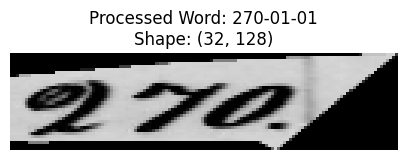


Cell 4: Word Image Cropping and Normalization function defined and tested (if samples were available).


In [14]:
# --------------------------------------
# Cell 4: Word Image Cropping and Normalization Function
# --------------------------------------
# Make sure OpenCV (cv2) and NumPy (np) are imported from Cell 1.
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt # For testing

def crop_and_process_word(full_image_bgr, polygon_points, target_size=(150, 50)):
    """
    Crops a word from a full-page image using its polygon, then resizes,
    converts to grayscale, and normalizes it.

    Args:
        full_image_bgr (numpy.ndarray): The full-page image loaded by OpenCV (BGR format).
        polygon_points (list or np.array): A list of (x, y) tuples or a NumPy array
                                           of shape (N, 2) representing the word's boundary.
                                           Coordinates should be floats or integers.
        target_size (tuple): A tuple (width, height) for resizing the cropped word image.

    Returns:
        numpy.ndarray: The processed word image (grayscale, normalized to [0,1])
                       or None if cropping fails.
    """
    if full_image_bgr is None:
        print("Error: Full image is None.")
        return None
    if not polygon_points or len(polygon_points) < 3:
        print("Error: Polygon points are insufficient.")
        return None

    # Convert polygon_points to a NumPy array of int32, as required by some OpenCV functions
    # OpenCV typically expects integer coordinates for drawing and ROI selection.
    # Since our points are floats from SVG, we'll round them.
    polygon_np = np.array(polygon_points, dtype=np.int32)

    # 1. Create a mask for the polygon
    mask = np.zeros(full_image_bgr.shape[:2], dtype=np.uint8) # Use only height, width for mask
    cv2.fillPoly(mask, [polygon_np], 255) # Fill the polygon area with white

    # 2. Get the bounding rectangle of the polygon to define the region of interest (ROI)
    x, y, w, h = cv2.boundingRect(polygon_np)

    # Ensure the bounding box is within the image dimensions
    if x < 0: x = 0
    if y < 0: y = 0
    if x + w > full_image_bgr.shape[1]: w = full_image_bgr.shape[1] - x
    if y + h > full_image_bgr.shape[0]: h = full_image_bgr.shape[0] - y

    if w <= 0 or h <= 0:
        # print(f"Warning: Invalid bounding box for polygon {polygon_points} -> x:{x} y:{y} w:{w} h:{h}")
        return None

    # 3. Extract the ROI from the original image and the mask
    roi_image = full_image_bgr[y:y+h, x:x+w]
    roi_mask = mask[y:y+h, x:x+w]

    # 4. Apply the mask to the ROI to get only the word pixels
    # This will make pixels outside the polygon black in the ROI
    masked_roi = cv2.bitwise_and(roi_image, roi_image, mask=roi_mask)

    # At this point, masked_roi contains the word on a black background,
    # but still within its bounding rectangle.

    # 5. Convert to grayscale
    gray_word = cv2.cvtColor(masked_roi, cv2.COLOR_BGR2GRAY)

    # 6. Resize to target_size
    # INTER_AREA is generally good for shrinking, INTER_LINEAR or INTER_CUBIC for enlarging.
    # INTER_LINEAR is a good default.
    resized_word = cv2.resize(gray_word, target_size, interpolation=cv2.INTER_LINEAR)

    # 7. Normalize pixel values to [0, 1]
    normalized_word = resized_word.astype(np.float32) / 255.0

    # (Optional: if you prefer [-1, 1] normalization)
    # normalized_word = (resized_word.astype(np.float32) / 127.5) - 1.0

    return normalized_word

# --- Test the function ---
# We need:
# 1. A sample full-page image path.
# 2. A sample set of polygon points for a word in that image (from parse_svg).

if train_doc_ids and 'parsed_paths' in locals() and parsed_paths: # Check if previous cell's test variables are available
    sample_doc_id_for_crop_test = train_doc_ids[0] # e.g., "270"
    sample_image_file_for_crop_test = os.path.join(IMAGES_PATH, f"{sample_doc_id_for_crop_test}.jpg")

    if os.path.exists(sample_image_file_for_crop_test):
        # Get the first word_id and its polygon from the previously parsed sample SVG
        # (parsed_paths was the output of parse_svg in the test section of Cell 3)
        first_word_id = None
        first_polygon_points = None
        if parsed_paths: # Ensure parsed_paths is not empty
            # Get the first item from the dictionary
            try:
                first_word_id = next(iter(parsed_paths))
                first_polygon_points = parsed_paths[first_word_id]
            except StopIteration:
                print("Error: parsed_paths dictionary is empty.")

        if first_word_id and first_polygon_points:
            print(f"\nTesting word cropping with: {sample_image_file_for_crop_test}")
            print(f"Using word_id: {first_word_id} with {len(first_polygon_points)} points.")

            # Load the full image
            full_image = cv2.imread(sample_image_file_for_crop_test)
            if full_image is not None:
                processed_word_image = crop_and_process_word(full_image, first_polygon_points, target_size=(128, 32)) # Example target size

                if processed_word_image is not None:
                    print(f"Successfully cropped and processed word. Shape: {processed_word_image.shape}")

                    # Display the processed word image
                    plt.figure(figsize=(5,2)) # Adjust figure size as needed
                    plt.imshow(processed_word_image, cmap='gray', vmin=0, vmax=1) # Assuming [0,1] normalization
                    plt.title(f"Processed Word: {first_word_id}\nShape: {processed_word_image.shape}")
                    plt.axis('off') # Turn off axis numbers and ticks
                    plt.show()
                else:
                    print("Failed to crop or process the sample word.")
            else:
                print(f"Failed to load sample image: {sample_image_file_for_crop_test}")
        else:
            print("Could not get sample polygon points from previous cell's test output (parsed_paths).")
    else:
        print(f"Sample image file not found for testing crop function: {sample_image_file_for_crop_test}")
else:
    print("Prerequisites for testing crop function not met (train_doc_ids or parsed_paths from Cell 3 test).")

print("\nCell 4: Word Image Cropping and Normalization function defined and tested (if samples were available).")

In [15]:
# --------------------------------------
# Cell 5: Process Training Data - Generate and Save Cropped Words & Metadata
# --------------------------------------
# Ensure necessary variables from previous cells are available:
# train_doc_ids (from Cell 2)
# transcriptions_df (from Cell 2, with 'word_id' as index and also as a column)
# keywords_set (from Cell 2)
# IMAGES_PATH, LOCATIONS_PATH (from Cell 1)
# CROPPED_TRAIN_PATH (from Cell 1, directory should exist)
# parse_svg (function from Cell 3)
# crop_and_process_word (function from Cell 4)
# import os (from Cell 1)
# import cv2 (from Cell 1)
# import pandas as pd (from Cell 2)
# import numpy as np (from Cell 1)
# from tqdm import tqdm # Optional: for a progress bar during long loops

# Define the target size for cropped images (should be consistent with Cell 4 test if you liked that size)
TARGET_IMG_SIZE = (128, 32) # (width, height) - same as used in Cell 4 test

training_data_metadata = []
print(f"Starting processing for {len(train_doc_ids)} training documents...")
print(f"Cropped images will be saved to: {CROPPED_TRAIN_PATH}")

# Optional: For progress tracking if you have many documents
# from tqdm import tqdm
# for doc_id in tqdm(train_doc_ids, desc="Processing Training Documents"):

for doc_id in train_doc_ids:
    print(f"Processing document: {doc_id}...")
    full_image_path = os.path.join(IMAGES_PATH, f"{doc_id}.jpg")
    svg_file_path = os.path.join(LOCATIONS_PATH, f"{doc_id}.svg")

    if not os.path.exists(full_image_path):
        print(f"Warning: Image file not found for doc_id {doc_id} at {full_image_path}. Skipping.")
        continue
    if not os.path.exists(svg_file_path):
        print(f"Warning: SVG file not found for doc_id {doc_id} at {svg_file_path}. Skipping.")
        continue

    # Load the full-page image once per document
    full_page_image = cv2.imread(full_image_path)
    if full_page_image is None:
        print(f"Warning: Could not load image {full_image_path}. Skipping document {doc_id}.")
        continue

    # Parse the SVG to get word locations and IDs for the current document
    # word_polygons_map is a dictionary: {word_id: polygon_points}
    word_polygons_map = parse_svg(svg_file_path)
    if not word_polygons_map:
        print(f"Warning: No polygons found in SVG for doc_id {doc_id}. Skipping.")
        continue

    num_words_in_doc = 0
    for word_id, polygon_points in word_polygons_map.items():
        # Crop and process the word image
        # The crop_and_process_word function expects the loaded image (full_page_image), not the path
        processed_image_np = crop_and_process_word(full_page_image, polygon_points, target_size=TARGET_IMG_SIZE)

        if processed_image_np is not None:
            # Define a save path for the cropped image (e.g., using word_id.png)
            # Ensure word_id is filename-safe (though DDD-LL-WW format should be fine)
            cropped_image_filename = f"{word_id}.png"
            saved_cropped_image_path = os.path.join(CROPPED_TRAIN_PATH, cropped_image_filename)

            # Save the processed image.
            # cv2.imwrite expects pixel values in [0, 255] and uint8 type.
            # Our processed_image_np is float32 in [0, 1].
            image_to_save = (processed_image_np * 255.0).astype(np.uint8)
            try:
                cv2.imwrite(saved_cropped_image_path, image_to_save)
            except Exception as e:
                print(f"Error saving image {saved_cropped_image_path}: {e}")
                continue # Skip this word if saving failed

            # Look up the transcription for this word_id
            actual_transcription_text = None
            try:
                # transcriptions_df has word_id as index
                actual_transcription_text = transcriptions_df.loc[word_id, 'transcription']
            except KeyError:
                print(f"Warning: Transcription not found for word_id '{word_id}' in document '{doc_id}'.")
                actual_transcription_text = "UNKNOWN" # Or handle as you see fit

            # Determine if the transcription is a keyword
            # keywords_set contains keywords from keywords.tsv (already in dashed format)
            is_keyword = actual_transcription_text in keywords_set
            keyword_text_if_match = actual_transcription_text if is_keyword else None

            # Append metadata
            training_data_metadata.append({
                'doc_id': doc_id, # Adding original document ID for reference
                'word_id': word_id,
                'image_path': saved_cropped_image_path,
                'transcription': actual_transcription_text,
                'is_keyword': is_keyword,
                'keyword_text': keyword_text_if_match
            })
            num_words_in_doc +=1
        # else:
            # print(f"Warning: Failed to process word_id '{word_id}' in document '{doc_id}'.")
    print(f"  Processed and saved {num_words_in_doc} words from document {doc_id}.")


# Convert metadata list to a pandas DataFrame
training_metadata_df = pd.DataFrame(training_data_metadata)

# Save the metadata DataFrame for easy reloading
metadata_save_path = os.path.join(KWS_DATA_PATH, 'training_metadata.csv')
try:
    training_metadata_df.to_csv(metadata_save_path, index=False)
    print(f"\nTraining metadata saved to: {metadata_save_path}")
except Exception as e:
    print(f"\nError saving training metadata CSV: {e}")

# Print some information about the created metadata
if not training_metadata_df.empty:
    print(f"\nTotal training words processed: {len(training_metadata_df)}")
    print(f"Number of identified keywords in training set: {training_metadata_df['is_keyword'].sum()}")
    print("\nTraining Metadata DataFrame head:")
    print(training_metadata_df.head())
else:
    print("\nNo training data was processed or metadata generated.")

print("\nCell 5: Processing Training Data complete.")

Starting processing for 10 training documents...
Cropped images will be saved to: /content/KWS/cropped_words/train
Processing document: 270...
  Processed and saved 221 words from document 270.
Processing document: 271...
  Processed and saved 274 words from document 271.
Processing document: 272...
  Processed and saved 249 words from document 272.
Processing document: 273...
  Processed and saved 231 words from document 273.
Processing document: 274...
  Processed and saved 259 words from document 274.
Processing document: 275...
  Processed and saved 269 words from document 275.
Processing document: 276...
  Processed and saved 235 words from document 276.
Processing document: 277...
  Processed and saved 245 words from document 277.
Processing document: 278...
  Processed and saved 207 words from document 278.
Processing document: 279...
  Processed and saved 243 words from document 279.

Training metadata saved to: /content/KWS/training_metadata.csv

Total training words processed

In [16]:
# --------------------------------------
# Cell 6: Prepare Image Pairs for Siamese Network
# --------------------------------------
import random
# Ensure training_metadata_df is loaded or available from Cell 5
# If not, load it:
# metadata_load_path = os.path.join(KWS_DATA_PATH, 'training_metadata.csv')
# if os.path.exists(metadata_load_path):
#     training_metadata_df = pd.read_csv(metadata_load_path)
#     print("Loaded training_metadata.csv")
# else:
#     print("ERROR: training_metadata.csv not found. Please re-run Cell 5.")
#     # Or stop execution if it's critical

# Separate keywords and non-keywords from the training metadata
if 'training_metadata_df' in locals() and not training_metadata_df.empty:
    keywords_df_train = training_metadata_df[training_metadata_df['is_keyword'] == True].copy()
    non_keywords_df_train = training_metadata_df[training_metadata_df['is_keyword'] == False].copy()

    print(f"Number of keyword instances in training: {len(keywords_df_train)}")
    print(f"Number of non-keyword instances in training: {len(non_keywords_df_train)}")
else:
    print("Error: training_metadata_df is not available or empty. Cannot proceed.")
    # Handle error: stop or skip
    keywords_df_train = pd.DataFrame()
    non_keywords_df_train = pd.DataFrame()

image_pairs = [] # To store (image_path1, image_path2)
labels = []      # To store 1 for positive pair, 0 for negative pair

# --- Create Positive Pairs ---
# For each keyword, find all its instances and create pairs.
# Group keyword instances by their 'keyword_text' (actual transcription of the keyword)
if not keywords_df_train.empty:
    grouped_keywords = keywords_df_train.groupby('keyword_text')

    for keyword_text, group in grouped_keywords:
        keyword_instances = group['image_path'].tolist()
        if len(keyword_instances) >= 2: # Need at least two instances to form a pair
            # Create all possible pairs (or a subset if too many)
            # For simplicity, let's make pairs: (img1,img2), (img1,img3)...(img2,img3)...
            for i in range(len(keyword_instances)):
                for j in range(i + 1, len(keyword_instances)):
                    image_pairs.append((keyword_instances[i], keyword_instances[j]))
                    labels.append(1) # Positive pair
    print(f"Generated {labels.count(1)} positive pairs.")
else:
    print("No keyword instances found to generate positive pairs.")


# --- Create Negative Pairs ---
# Aim for a somewhat balanced number of negative pairs relative to positive pairs.
# Or a fixed number of negative pairs per anchor.
num_positive_pairs = labels.count(1)
num_negative_pairs_to_generate = num_positive_pairs * 2 # Aim for twice as many negative pairs, can be adjusted

if not keywords_df_train.empty and not non_keywords_df_train.empty and num_positive_pairs > 0:
    generated_negative_count = 0
    # Get lists of all keyword image paths and non-keyword image paths
    all_keyword_image_paths = keywords_df_train['image_path'].tolist()
    all_keyword_transcriptions = keywords_df_train['transcription'].tolist() # To ensure we pick different keywords

    all_non_keyword_image_paths = non_keywords_df_train['image_path'].tolist()

    # For negative pairs, we can pair:
    # 1. A keyword instance with a non-keyword instance.
    # 2. A keyword instance with an instance of a *different* keyword.

    # Let's try to create num_negative_pairs_to_generate
    # Iterate through keyword instances as anchors

    # Safety break for while loop
    max_attempts_neg_pair = num_negative_pairs_to_generate * 5
    attempts = 0

    while generated_negative_count < num_negative_pairs_to_generate and attempts < max_attempts_neg_pair :
        attempts += 1
        # Pick a random keyword instance as anchor
        anchor_idx = random.randrange(len(all_keyword_image_paths))
        anchor_image_path = all_keyword_image_paths[anchor_idx]
        anchor_transcription = all_keyword_transcriptions[anchor_idx]

        # Decide to pair with a non-keyword or a different keyword
        if random.random() < 0.7 and len(all_non_keyword_image_paths) > 0: # 70% chance to pick a non-keyword
            negative_image_path = random.choice(all_non_keyword_image_paths)
        else: # Pick a different keyword
            # Ensure we pick a keyword with a different transcription
            possible_neg_keywords = [(path, trans) for path, trans in zip(all_keyword_image_paths, all_keyword_transcriptions) if trans != anchor_transcription]
            if not possible_neg_keywords: # If only one type of keyword or all remaining are same as anchor
                if len(all_non_keyword_image_paths) > 0: # Fallback to non-keyword
                     negative_image_path = random.choice(all_non_keyword_image_paths)
                else: # No other options
                    continue
            else:
                negative_image_path = random.choice(possible_neg_keywords)[0]

        # Add the negative pair if it's not identical (though unlikely with this sampling)
        if anchor_image_path != negative_image_path:
            image_pairs.append((anchor_image_path, negative_image_path))
            labels.append(0) # Negative pair
            generated_negative_count += 1

    print(f"Generated {labels.count(0)} negative pairs.")

else:
    print("Not enough data (keywords or non-keywords) or no positive pairs to generate negative pairs.")

# Shuffle the pairs and labels together
if image_pairs and labels:
    combined = list(zip(image_pairs, labels))
    random.shuffle(combined)
    image_pairs_shuffled, labels_shuffled = zip(*combined)

    image_pairs_final = list(image_pairs_shuffled)
    labels_final = list(labels_shuffled)

    print(f"\nTotal image pairs generated: {len(image_pairs_final)}")
    print(f"Number of positive pairs: {sum(labels_final)}")
    print(f"Number of negative pairs: {len(labels_final) - sum(labels_final)}")

    # Display a few example pairs
    print("\nExample pairs (path1, path2, label):")
    for i in range(min(5, len(image_pairs_final))):
        print(f"({os.path.basename(image_pairs_final[i][0])}, {os.path.basename(image_pairs_final[i][1])}, {labels_final[i]})")

    # We will need these lists (image_pairs_final, labels_final) for the data generator/loader in the training step.
    # For now, just having them in memory is fine.
    # If the dataset is very large, one might save these pairs to a file too.
else:
    print("\nNo image pairs were generated.")
    image_pairs_final = []
    labels_final = []


print("\nCell 6: Image pair preparation complete.")

Number of keyword instances in training: 167
Number of non-keyword instances in training: 2266
Generated 703 positive pairs.
Generated 1406 negative pairs.

Total image pairs generated: 2109
Number of positive pairs: 703
Number of negative pairs: 1406

Example pairs (path1, path2, label):
(270-16-02.png, 275-21-03.png, 0)
(276-36-02.png, 271-06-03.png, 0)
(270-33-04.png, 276-06-06.png, 1)
(273-01-02.png, 274-29-03.png, 0)
(276-24-06.png, 278-35-06.png, 0)

Cell 6: Image pair preparation complete.


In [17]:
# --------------------------------------
# Cell 7: Define Feature Extractor / Embedding Model
# --------------------------------------
# Ensure TensorFlow is imported. If not, you might need to install/import it.
# !pip install tensorflow # if not already installed
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2 # Using MobileNetV2 as a base

# Define the input shape for our word images
# This should match the TARGET_IMG_SIZE from Cell 5, but with a channel dimension.
# (height, width, channels) - grayscale has 1 channel.
# TARGET_IMG_SIZE was (width, height), so input_shape is (height, width, channels)
IMG_HEIGHT = TARGET_IMG_SIZE[1] # e.g., 32
IMG_WIDTH = TARGET_IMG_SIZE[0]  # e.g., 128
CHANNELS = 1 # Grayscale
input_shape = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)

# --- Option 1: Simple CNN from Scratch (if MobileNetV2 causes issues or for ultra-simplicity) ---
# This is a very basic CNN.
def create_simple_embedding_model(input_shape, embedding_dim=64):
    input_img = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x) # Shape might be small here, check

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    embedding = Dense(embedding_dim, activation=None)(x) # No activation for the embedding itself
                                                       # Or 'linear'

    model = Model(inputs=input_img, outputs=embedding, name="SimpleEmbeddingModel")
    return model

# --- Option 2: Using MobileNetV2 as a base (Recommended for better features) ---
# We need to adapt MobileNetV2 for grayscale input and our specific input size.
# MobileNetV2 expects 3 channels. We can either:
#   a) Modify the first layer (more complex)
#   b) Repeat our grayscale channel 3 times to simulate RGB (simpler to implement)
#   c) Add a Conv2D layer before MobileNetV2 to project 1 channel to 3.

def create_mobilenet_embedding_model(input_shape, embedding_dim=128):
    # Input will be our grayscale image
    grayscale_input = Input(shape=input_shape, name="grayscale_input")

    # Option b: Repeat grayscale channel to simulate RGB for MobileNetV2
    # This might require input_shape to be (height, width, 1)
    # and then we process it.
    # Or, more directly, add a conv layer to project to 3 channels if input is (H, W, 1)
    if input_shape[-1] == 1: # If input is grayscale
        # Add a convolutional layer to project 1 channel to 3 channels
        # This layer learns to create a 3-channel representation from grayscale
        x = Conv2D(3, (1, 1), padding='same', activation='relu', name="project_to_rgb")(grayscale_input)
    else: # If input is already 3 channels (e.g., if we decided to load as RGB)
        x = grayscale_input

    # Ensure the input size for MobileNetV2 is at least 32x32.
    # Our TARGET_IMG_SIZE is (128, 32) or (width, height)
    # MobileNetV2 input_shape=(height, width, 3)
    # If our height or width is less than 32, MobileNetV2 might not work well or at all.
    # Our (32, 128, 3) should be fine.

    base_mobilenet = MobileNetV2(
        input_shape=(input_shape[0], input_shape[1], 3), # Expects 3 channels now
        include_top=False, # We don't want the classification layer
        weights='imagenet', # Load pre-trained ImageNet weights
        pooling='avg' # Global Average Pooling at the end of MobileNetV2
    )

    # Freeze the layers of the pre-trained model so we don't update their weights during initial training
    # for layer in base_mobilenet.layers:
    #     layer.trainable = False
    # It's often better to fine-tune a few top layers of base_mobilenet, but for simplicity, let's try freezing all first or making them trainable.
    # For keyword spotting, making base layers trainable might be beneficial if data is sufficient. Let's make it trainable.
    base_mobilenet.trainable = True # Or set specific layers to trainable=False

    # Get the output of the base model
    base_output = base_mobilenet(x) # Pass our (now 3-channel) input through MobileNetV2

    # Add our custom dense layers for the embedding
    # base_output is already pooled due to `pooling='avg'`
    dense_embedding = Dense(embedding_dim, activation=None, name="embedding_vector")(base_output) # Linear activation for embedding

    model = Model(inputs=grayscale_input, outputs=dense_embedding, name="MobileNetEmbeddingModel")
    return model


# --- Choose one model to instantiate ---
EMBEDDING_DIMENSION = 128 # You can experiment with this, e.g., 64, 128, 256

# Instantiate the chosen embedding model
# Option 1: Simple Model (faster to train, might be less accurate)
# embedding_model = create_simple_embedding_model(input_shape, embedding_dim=EMBEDDING_DIMENSION)

# Option 2: MobileNetV2 based (potentially more accurate, might take longer to train)
embedding_model = create_mobilenet_embedding_model(input_shape, embedding_dim=EMBEDDING_DIMENSION)


# Print model summary to verify its structure
embedding_model.summary()

print(f"\nCell 7: Embedding model ('{embedding_model.name}') defined with embedding dimension {EMBEDDING_DIMENSION}.")
print(f"Input shape for embedding model: {input_shape}")

<ipython-input-17-08f1030ee8c3>:70: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_mobilenet = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "MobileNetEmbeddingModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ grayscale_input (InputLayer)    │ (None, 32, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ project_to_rgb (Conv2D)         │ (None, 32, 128, 3)     │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_vector (Dense)        │ (None, 128)            │       163,968 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,421,958 (9.24 MB)

 Trainable params: 2,387,846 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)


Cell 7: Embedding model ('MobileNetEmbeddingModel') defined with embedding dimension 128.
Input shape for embedding model: (32, 128, 1)


In [18]:
# --------------------------------------
# Cell 8: Define Siamese Network Architecture and Loss
# --------------------------------------
# Ensure TensorFlow and necessary Keras layers are imported from Cell 1 / Cell 7
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Lambda, Dense
# from tensorflow.keras.models import Model
# embedding_model should be available from Cell 7
# input_shape should be available from Cell 7

# The embedding_model defined in Cell 7 will be shared by both inputs (towers) of the Siamese network.

# 1. Define the input layers for the pair of images
input_a = Input(shape=input_shape, name="left_input")
input_b = Input(shape=input_shape, name="right_input")

# 2. Get embeddings for each input using the shared embedding_model
embedding_a = embedding_model(input_a)
embedding_b = embedding_model(input_b)

# 3. Calculate the distance between the embeddings
# We can use Euclidean distance or L1 distance.
# Keras Lambda layer allows us to use custom functions.
def euclidean_distance(vectors):
    x, y = vectors
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

# L1 distance might be more robust for high-dimensional sparse data,
# but Euclidean is common. Let's use Euclidean.
# distance = Lambda(euclidean_distance, name="euclidean_distance")([embedding_a, embedding_b])

# Alternatively, for L1 distance:
def l1_distance(vectors):
    x, y = vectors
    return tf.reduce_sum(tf.abs(x - y), axis=1, keepdims=True)

distance = Lambda(l1_distance, name="l1_distance")([embedding_a, embedding_b])


# 4. Add a final Dense layer with sigmoid activation for similarity prediction
# The output should be a single value between 0 (dissimilar) and 1 (similar).
similarity_output = Dense(1, activation='sigmoid', name="similarity_score")(distance)

# 5. Create the Siamese Model
siamese_network = Model(inputs=[input_a, input_b], outputs=similarity_output, name="SiameseNetwork")

# Print model summary
siamese_network.summary()

# 6. Define the Contrastive Loss function
# margin is a hyperparameter
MARGIN = 1.0 # Common value for margin in contrastive loss

def contrastive_loss(y_true, y_pred):
    """
    Contrastive loss function.
    y_true: 1 for positive pair, 0 for negative pair.
    y_pred: The predicted similarity score (output of the network, which is derived from distance).
            For contrastive loss, y_pred usually refers to the distance (d) directly.
            However, our network outputs a similarity score (sigmoid of distance).
            Let's adapt or use a loss that works with similarity scores, or re-evaluate.

            If y_pred is distance 'd':
            Loss = y_true * d^2 + (1 - y_true) * max(0, margin - d)^2

            If our y_pred is similarity 's' (sigmoid of distance), it's a bit different.
            Typically, if using a distance layer followed by a sigmoid for similarity,
            you would use Binary Cross-Entropy on the final similarity score.
            The 'distance' variable in our network is the L1 distance 'd'.
            The 'similarity_output' is sigmoid(d) (or sigmoid(W*d+b) if Dense has weights).

            Let's use Binary Cross-Entropy as our network is structured to predict similarity (0 or 1).
            The labels (y_true) are already 0 for dissimilar and 1 for similar.
    """
    # y_true: 0 for negative, 1 for positive
    # y_pred: similarity score from sigmoid (0 to 1)
    return tf.keras.losses.binary_crossentropy(y_true, y_pred)

# If we strictly wanted to implement the classic contrastive loss based on distance 'd'
# we would have to make the 'distance' layer the output of the siamese network for loss calculation purposes,
# or pass 'distance' to the loss function.
# Using Binary Cross-Entropy with the current sigmoid output is simpler and standard for similarity tasks.

print("\nCell 8: Siamese Network architecture defined and loss function (Binary Cross-Entropy) selected.")
print(f"Inputs: [left_input: {input_a.shape}, right_input: {input_b.shape}]")
print(f"Output: similarity_score: {similarity_output.shape}")
print(f"Using L1 distance for comparing embeddings.")

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ left_input          │ (None, 32, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ right_input         │ (None, 32, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MobileNetEmbedding… │ (None, 128)       │  2,421,958 │ left_input[0][0], │
│ (Functional)        │                   │            │ right_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_distance         │ (None, 1)         │          0 │ MobileNetEmbeddi… │
│ (Lambda)            │                   │            │ MobileNetEmbeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ similarity_score    │ (None, 1)         │          2 │ l1_distance[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,421,960 (9.24 MB)

 Trainable params: 2,387,848 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)


Cell 8: Siamese Network architecture defined and loss function (Binary Cross-Entropy) selected.
Inputs: [left_input: (None, 32, 128, 1), right_input: (None, 32, 128, 1)]
Output: similarity_score: (None, 1)
Using L1 distance for comparing embeddings.



Siamese Network compiled.
Batch Size: 32, Epochs: 10, Learning Rate: 0.0001
Steps per epoch: 66

Starting training...
Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 118s 984ms/step - accuracy: 0.6617 - loss: 23.8068
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 996ms/step - accuracy: 0.6629 - loss: 4.6360
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 997ms/step - accuracy: 0.7483 - loss: 0.7825
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 65s 983ms/step - accuracy: 0.8306 - loss: 0.4533
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 64s 978ms/step - accuracy: 0.8487 - loss: 0.3896
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 64s 970ms/step - accuracy: 0.8479 - loss: 0.3566
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 64s 966ms/step - accuracy: 0.8747 - loss: 0.3352
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 65s 980ms/step - accuracy: 0.8807 - loss: 0.3280
Epoch 9/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 65s 981ms/step - accuracy: 0.9106 - loss: 0.3059
Epoch 10/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 65s 983ms/step - accuracy: 0.8988 - loss: 0.3020

Trainin

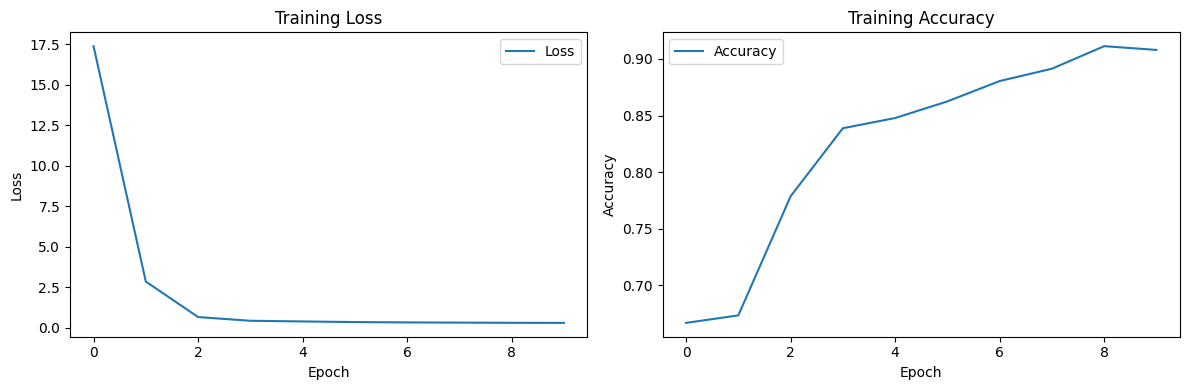


Cell 9: Training Loop execution finished.


In [20]:
# --------------------------------------
# Cell 9: Training Loop (Corrected)
# --------------------------------------
# Ensure TensorFlow, Keras items, image_pairs_final, labels_final,
# siamese_network, contrastive_loss (binary_crossentropy), input_shape
# are available from previous cells.
import tensorflow as tf
import numpy as np
import cv2 # For image loading
import os
import matplotlib.pyplot as plt # Make sure it's imported for plotting

# Hyperparameters for training
BATCH_SIZE = 32
EPOCHS = 10 # Start with a small number of epochs to verify the pipeline
LEARNING_RATE = 0.0001 # A smaller learning rate is often good for fine-tuning

# 1. Create a Data Generator
def siamese_data_generator(image_paths_pairs, pair_labels, batch_size, target_img_shape):
    """
    Generates batches of image pairs and labels for training the Siamese network.
    Args:
        image_paths_pairs (list): List of tuples, where each tuple is (path_img_a, path_img_b).
        pair_labels (list): List of labels (0 or 1) for each pair.
        batch_size (int): The size of each batch.
        target_img_shape (tuple): Expected shape of the image (height, width, channels).
    """
    num_samples = len(image_paths_pairs)
    height, width, channels = target_img_shape

    while True: # Loop indefinitely so the generator doesn't stop
        for offset in range(0, num_samples, batch_size):
            batch_paths_pairs = image_paths_pairs[offset:offset+batch_size]
            batch_labels = np.array(pair_labels[offset:offset+batch_size])

            if not batch_paths_pairs:
                continue

            batch_images_a = np.zeros((len(batch_paths_pairs), height, width, channels), dtype=np.float32)
            batch_images_b = np.zeros((len(batch_paths_pairs), height, width, channels), dtype=np.float32)

            for i, (path_a, path_b) in enumerate(batch_paths_pairs):
                try:
                    img_a = cv2.imread(path_a, cv2.IMREAD_GRAYSCALE)
                    if img_a is None:
                        # print(f"Warning: Could not load image {path_a}. Filling with zeros.")
                        img_a = np.zeros((height, width), dtype=np.uint8) # Default to black image
                        # continue # Or skip this pair by not incrementing 'i' effectively or removing from batch

                    img_a_processed = cv2.resize(img_a, (width, height)).astype(np.float32) / 255.0
                    batch_images_a[i] = np.expand_dims(img_a_processed, axis=-1)

                    img_b = cv2.imread(path_b, cv2.IMREAD_GRAYSCALE)
                    if img_b is None:
                        # print(f"Warning: Could not load image {path_b}. Filling with zeros.")
                        img_b = np.zeros((height, width), dtype=np.uint8) # Default to black image
                        # continue
                    img_b_processed = cv2.resize(img_b, (width, height)).astype(np.float32) / 255.0
                    batch_images_b[i] = np.expand_dims(img_b_processed, axis=-1)

                except Exception as e:
                    print(f"Error loading/processing image pair ({path_a}, {path_b}): {e}")
                    # Images might remain zeros if error occurs

            # ***** THIS IS THE CORRECTED LINE *****
            yield ((batch_images_a, batch_images_b), batch_labels)
            # *************************************

# Instantiate the generator
train_generator = siamese_data_generator(image_pairs_final, labels_final, BATCH_SIZE, input_shape)

# Calculate steps_per_epoch
steps_per_epoch = len(image_pairs_final) // BATCH_SIZE
if len(image_pairs_final) % BATCH_SIZE != 0:
    steps_per_epoch += 1

# 2. Compile the Siamese network
# contrastive_loss is actually binary_crossentropy as defined in Cell 8
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
siamese_network.compile(loss=contrastive_loss, optimizer=optimizer, metrics=['accuracy'])

print("\nSiamese Network compiled.")
print(f"Batch Size: {BATCH_SIZE}, Epochs: {EPOCHS}, Learning Rate: {LEARNING_RATE}")
print(f"Steps per epoch: {steps_per_epoch}")

# 3. Train the model
if image_pairs_final and steps_per_epoch > 0:
    print("\nStarting training...")
    history = siamese_network.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        verbose=1
    )
    print("\nTraining complete.")

    if history:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Loss')
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Accuracy')
        plt.title('Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()
else:
    print("\nNo data or image pairs available for training. Skipping model fitting.")

print("\nCell 9: Training Loop execution finished.")

In [21]:
# --------------------------------------
# Cell 10: Process Validation Data
# --------------------------------------
# Ensure necessary variables from previous cells are available:
# validation_doc_ids (from Cell 2)
# transcriptions_df (from Cell 2, with 'word_id' as index and also as a column)
# keywords_set (from Cell 2)
# IMAGES_PATH, LOCATIONS_PATH (from Cell 1)
# CROPPED_VALIDATION_PATH (from Cell 1, directory should exist)
# parse_svg (function from Cell 3)
# crop_and_process_word (function from Cell 4)
# TARGET_IMG_SIZE (defined in Cell 5, or re-define here if needed, e.g., (128,32))
# import os (from Cell 1)
# import cv2 (from Cell 1)
# import pandas as pd (from Cell 2)
# import numpy as np (from Cell 1)
# from tqdm import tqdm # Optional: for a progress bar

# Re-affirm TARGET_IMG_SIZE if not carried over, ensure it's the same as used for training
if 'TARGET_IMG_SIZE' not in locals():
    TARGET_IMG_SIZE = (128, 32) # (width, height) - ensure this matches training
    print(f"TARGET_IMG_SIZE was not defined, setting to {TARGET_IMG_SIZE}")


validation_data_metadata = []
print(f"Starting processing for {len(validation_doc_ids)} validation documents...")
print(f"Cropped validation images will be saved to: {CROPPED_VALIDATION_PATH}")

# Optional: For progress tracking
# from tqdm import tqdm
# for doc_id in tqdm(validation_doc_ids, desc="Processing Validation Documents"):

for doc_id in validation_doc_ids:
    print(f"Processing document: {doc_id}...")
    full_image_path = os.path.join(IMAGES_PATH, f"{doc_id}.jpg")
    svg_file_path = os.path.join(LOCATIONS_PATH, f"{doc_id}.svg")

    if not os.path.exists(full_image_path):
        print(f"Warning: Image file not found for doc_id {doc_id} at {full_image_path}. Skipping.")
        continue
    if not os.path.exists(svg_file_path):
        print(f"Warning: SVG file not found for doc_id {doc_id} at {svg_file_path}. Skipping.")
        continue

    # Load the full-page image once per document
    full_page_image = cv2.imread(full_image_path)
    if full_page_image is None:
        print(f"Warning: Could not load image {full_image_path}. Skipping document {doc_id}.")
        continue

    # Parse the SVG to get word locations and IDs
    word_polygons_map = parse_svg(svg_file_path)
    if not word_polygons_map:
        print(f"Warning: No polygons found in SVG for doc_id {doc_id}. Skipping.")
        continue

    num_words_in_doc_val = 0
    for word_id, polygon_points in word_polygons_map.items():
        processed_image_np = crop_and_process_word(full_page_image, polygon_points, target_size=TARGET_IMG_SIZE)

        if processed_image_np is not None:
            cropped_image_filename = f"{word_id}.png"
            # Save to the validation cropped images directory
            saved_cropped_image_path = os.path.join(CROPPED_VALIDATION_PATH, cropped_image_filename)

            image_to_save = (processed_image_np * 255.0).astype(np.uint8)
            try:
                cv2.imwrite(saved_cropped_image_path, image_to_save)
            except Exception as e:
                print(f"Error saving image {saved_cropped_image_path}: {e}")
                continue

            actual_transcription_text = None
            try:
                actual_transcription_text = transcriptions_df.loc[word_id, 'transcription']
            except KeyError:
                print(f"Warning: Transcription not found for word_id '{word_id}' in validation document '{doc_id}'.")
                actual_transcription_text = "UNKNOWN"

            is_keyword = actual_transcription_text in keywords_set
            keyword_text_if_match = actual_transcription_text if is_keyword else None

            validation_data_metadata.append({
                'doc_id': doc_id,
                'word_id': word_id,
                'image_path': saved_cropped_image_path,
                'transcription': actual_transcription_text,
                'is_keyword': is_keyword,
                'keyword_text': keyword_text_if_match
            })
            num_words_in_doc_val +=1
    print(f"  Processed and saved {num_words_in_doc_val} words from document {doc_id}.")


# Convert metadata list to a pandas DataFrame
validation_metadata_df = pd.DataFrame(validation_data_metadata)

# Save the metadata DataFrame
validation_metadata_save_path = os.path.join(KWS_DATA_PATH, 'validation_metadata.csv')
try:
    validation_metadata_df.to_csv(validation_metadata_save_path, index=False)
    print(f"\nValidation metadata saved to: {validation_metadata_save_path}")
except Exception as e:
    print(f"\nError saving validation metadata CSV: {e}")

# Print some information about the created metadata
if not validation_metadata_df.empty:
    print(f"\nTotal validation words processed: {len(validation_metadata_df)}")
    print(f"Number of identified keywords in validation set: {validation_metadata_df['is_keyword'].sum()}")
    print("\nValidation Metadata DataFrame head:")
    print(validation_metadata_df.head())
else:
    print("\nNo validation data was processed or metadata generated.")

print("\nCell 10: Processing Validation Data complete.")

Starting processing for 5 validation documents...
Cropped validation images will be saved to: /content/KWS/cropped_words/validation
Processing document: 300...
  Processed and saved 203 words from document 300.
Processing document: 301...
  Processed and saved 276 words from document 301.
Processing document: 302...
  Processed and saved 266 words from document 302.
Processing document: 303...
  Processed and saved 306 words from document 303.
Processing document: 304...
  Processed and saved 242 words from document 304.

Validation metadata saved to: /content/KWS/validation_metadata.csv

Total validation words processed: 1293
Number of identified keywords in validation set: 70

Validation Metadata DataFrame head:
  doc_id    word_id                                         image_path  \
0    300  300-02-01  /content/KWS/cropped_words/validation/300-02-0...   
1    300  300-02-02  /content/KWS/cropped_words/validation/300-02-0...   
2    300  300-02-03  /content/KWS/cropped_words/valida

In [22]:
# --------------------------------------
# Cell 11: Generate Embeddings for Validation Set
# --------------------------------------
# Ensure necessary variables are available:
# validation_metadata_df (from Cell 10)
# embedding_model (from Cell 7 - this is the model that outputs the embedding vector)
# input_shape (from Cell 7 - (height, width, channels))
# TARGET_IMG_SIZE (defined in Cell 5 or 10, should match input_shape for height and width)
# import numpy as np
# import cv2
# import os
# from tqdm import tqdm # Optional for progress

# If validation_metadata_df is not in memory, load it
if 'validation_metadata_df' not in locals() or validation_metadata_df.empty:
    validation_metadata_load_path = os.path.join(KWS_DATA_PATH, 'validation_metadata.csv')
    if os.path.exists(validation_metadata_load_path):
        validation_metadata_df = pd.read_csv(validation_metadata_load_path)
        print("Loaded validation_metadata.csv")
    else:
        print("ERROR: validation_metadata.csv not found. Please re-run Cell 10.")
        # Or handle error to stop execution if critical
        validation_metadata_df = pd.DataFrame() # Create empty df to prevent further errors

if 'embedding_model' not in locals():
    print("ERROR: embedding_model not found. Please ensure Cell 7 was run successfully.")
    # Or handle error
if 'input_shape' not in locals():
     print("ERROR: input_shape not found. Please ensure Cell 7 was run successfully.")
    # Or handle error

# Re-affirm TARGET_IMG_SIZE if not carried over, ensure it's the same as used for training
if 'TARGET_IMG_SIZE' not in locals():
    TARGET_IMG_SIZE = (128, 32) # (width, height) - ensure this matches model input
    print(f"TARGET_IMG_SIZE was not defined, setting to {TARGET_IMG_SIZE}")

validation_embeddings = []
validation_word_ids_for_embeddings = [] # To keep track of which embedding belongs to which word_id

if not validation_metadata_df.empty and 'embedding_model' in locals() and 'input_shape' in locals():
    print(f"Generating embeddings for {len(validation_metadata_df)} validation words...")

    img_height, img_width, img_channels = input_shape

    # Optional: Use tqdm for a progress bar
    # for index, row in tqdm(validation_metadata_df.iterrows(), total=validation_metadata_df.shape[0], desc="Generating Validation Embeddings"):
    for index, row in validation_metadata_df.iterrows():
        image_path = row['image_path']
        word_id = row['word_id']

        if not os.path.exists(image_path):
            print(f"Warning: Image path {image_path} for word_id {word_id} does not exist. Skipping.")
            continue

        try:
            # Load the image (it was saved as grayscale uint8 [0,255])
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Could not load image {image_path} for word_id {word_id}. Skipping.")
                continue

            # Preprocess: resize (should already be target size, but good to ensure), normalize, expand dims
            img_processed = cv2.resize(img, (img_width, img_height)).astype(np.float32) / 255.0
            img_tensor = np.expand_dims(img_processed, axis=-1) # Shape: (height, width, 1)
            img_tensor = np.expand_dims(img_tensor, axis=0)    # Shape: (1, height, width, 1) for model prediction

            # Get embedding from the embedding_model
            embedding = embedding_model.predict(img_tensor, verbose=0) # verbose=0 to prevent print per prediction

            validation_embeddings.append(embedding[0]) # embedding_model returns (1, embedding_dim), so take [0]
            validation_word_ids_for_embeddings.append(word_id)

        except Exception as e:
            print(f"Error processing image {image_path} for word_id {word_id}: {e}")

    if validation_embeddings:
        validation_embeddings_np = np.array(validation_embeddings)
        print(f"\nSuccessfully generated {len(validation_embeddings_np)} embeddings.")
        print(f"Shape of validation_embeddings_np: {validation_embeddings_np.shape}") # Should be (num_val_words, embedding_dim)

        # Optional: Save embeddings for faster loading next time
        # np.save(os.path.join(KWS_DATA_PATH, 'validation_embeddings.npy'), validation_embeddings_np)
        # np.save(os.path.join(KWS_DATA_PATH, 'validation_word_ids_for_embeddings.npy'), np.array(validation_word_ids_for_embeddings))
        # print("Validation embeddings and corresponding word IDs saved.")
    else:
        print("\nNo embeddings were generated for the validation set.")
        validation_embeddings_np = np.array([])


else:
    print("Skipping validation embedding generation due to missing data or model.")
    validation_embeddings_np = np.array([])
    validation_word_ids_for_embeddings = []


print("\nCell 11: Generating Embeddings for Validation Set complete.")

Generating embeddings for 1293 validation words...

Successfully generated 1293 embeddings.
Shape of validation_embeddings_np: (1293, 128)

Cell 11: Generating Embeddings for Validation Set complete.



Performing 5 keyword spotting queries...

--- Query Word: 304-12-04 ('J-o-h-n') ---


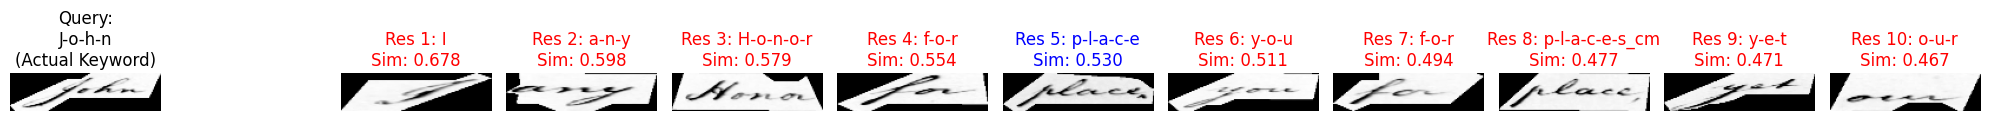


--- Query Word: 303-14-06 ('d-e') ---


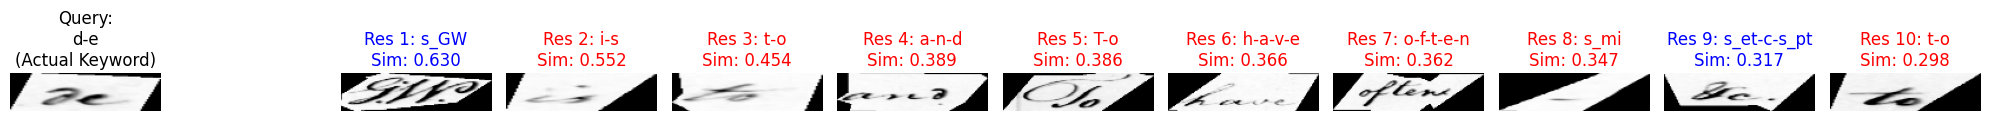


--- Query Word: 303-16-06 ('C-a-p-t-a-i-n') ---


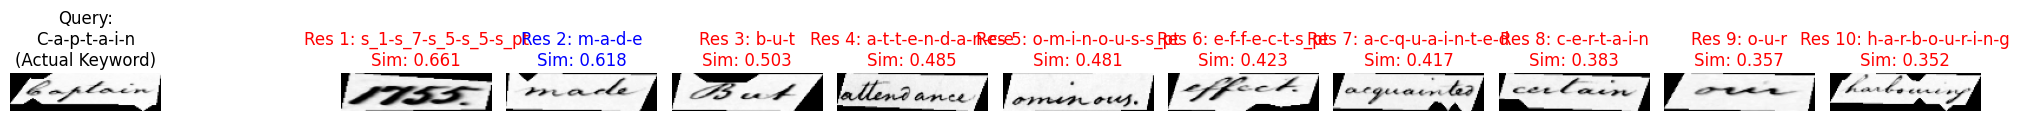


--- Query Word: 304-26-03 ('R-e-c-r-u-i-t-s') ---


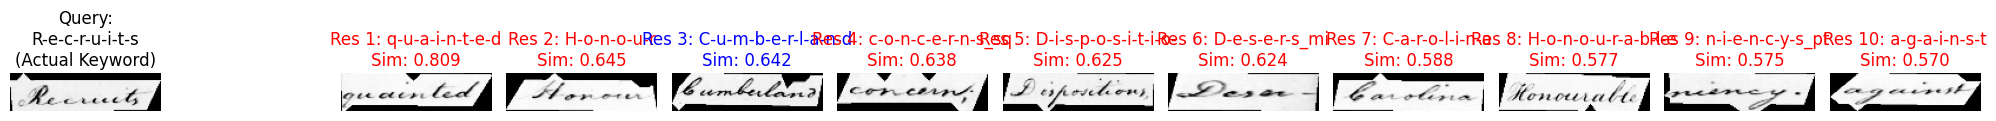


--- Query Word: 302-01-05 ('I-n-s-t-r-u-c-t-i-o-n-s-s_pt') ---


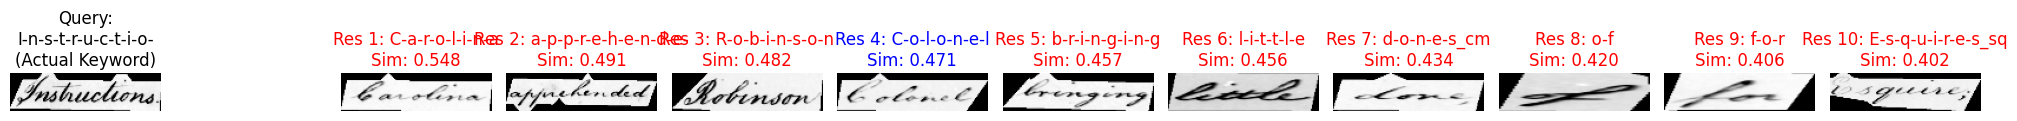


Cell 12: Keyword Spotting Evaluation (Basic) complete.


In [23]:
# --------------------------------------
# Cell 12: Keyword Spotting Evaluation (Basic)
# --------------------------------------
# Ensure necessary variables are available:
# validation_metadata_df (from Cell 10 or loaded in Cell 11)
# validation_embeddings_np (from Cell 11)
# validation_word_ids_for_embeddings (from Cell 11)
# keywords_set (from Cell 2)
# TARGET_IMG_SIZE (defined in previous cells)
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# import os
from sklearn.metrics.pairwise import cosine_similarity # For calculating similarity

# If validation_metadata_df or embeddings are not in memory, load them
if 'validation_metadata_df' not in locals() or validation_metadata_df.empty:
    validation_metadata_load_path = os.path.join(KWS_DATA_PATH, 'validation_metadata.csv')
    if os.path.exists(validation_metadata_load_path):
        validation_metadata_df = pd.read_csv(validation_metadata_load_path)
        print("Loaded validation_metadata.csv for evaluation.")
    else:
        print("ERROR: validation_metadata.csv not found. Please re-run Cell 10.")
        validation_metadata_df = pd.DataFrame()

if 'validation_embeddings_np' not in locals() or validation_embeddings_np.size == 0:
    val_embed_path = os.path.join(KWS_DATA_PATH, 'validation_embeddings.npy')
    val_ids_path = os.path.join(KWS_DATA_PATH, 'validation_word_ids_for_embeddings.npy')
    if os.path.exists(val_embed_path) and os.path.exists(val_ids_path):
        validation_embeddings_np = np.load(val_embed_path)
        validation_word_ids_for_embeddings = np.load(val_ids_path).tolist() # Ensure it's a list
        print("Loaded validation_embeddings.npy and validation_word_ids_for_embeddings.npy")
    else:
        print("ERROR: Validation embeddings not found. Please re-run Cell 11.")
        validation_embeddings_np = np.array([]) # Define to prevent error if not loaded

if 'TARGET_IMG_SIZE' not in locals(): # Should be defined from previous cells
    TARGET_IMG_SIZE = (128, 32)
    print(f"TARGET_IMG_SIZE not found, defaulting to {TARGET_IMG_SIZE}")


# --- Parameters for Evaluation ---
NUM_QUERIES = 5 # Number of random keyword queries to perform
TOP_N_RESULTS = 10 # Number of top similar images to display for each query

def display_image_results(query_img_path, query_transcription, result_tuples, target_img_size):
    """
    Displays the query image and the top N result images.
    result_tuples: list of (image_path, transcription, similarity_score)
    """
    num_results_to_show = len(result_tuples)
    plt.figure(figsize=(20, 2 + (num_results_to_show // 5) * 2)) # Adjust figure size

    # Display Query Image
    plt.subplot(1, num_results_to_show + 2, 1) # +2 to give some space or use a grid
    try:
        q_img = cv2.imread(query_img_path, cv2.IMREAD_GRAYSCALE)
        if q_img is not None:
            q_img_resized = cv2.resize(q_img, target_img_size)
            plt.imshow(q_img_resized, cmap='gray')
        else:
            plt.text(0.5, 0.5, 'Query N/A', ha='center', va='center')
    except Exception as e:
        plt.text(0.5, 0.5, f'Error Query:\n{e}', ha='center', va='center')
    plt.title(f"Query:\n{query_transcription[:20]}\n(Actual Keyword)") # Shorten if too long
    plt.axis('off')

    # Display Result Images
    for i, (img_path, transcription, score) in enumerate(result_tuples):
        plt.subplot(1, num_results_to_show + 2, i + 3) # Start plotting results from 3rd subplot
        try:
            r_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if r_img is not None:
                r_img_resized = cv2.resize(r_img, target_img_size)
                plt.imshow(r_img_resized, cmap='gray')
            else:
                 plt.text(0.5, 0.5, 'Res N/A', ha='center', va='center')
        except Exception as e:
            plt.text(0.5, 0.5, f'Error Res:\n{e}', ha='center', va='center')

        is_actually_keyword = transcription in keywords_set # Check if the result is a keyword
        title_color = 'green' if transcription == query_transcription else ('blue' if is_actually_keyword else 'red')
        plt.title(f"Res {i+1}: {transcription[:20]}\nSim: {score:.3f}", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

if not validation_metadata_df.empty and validation_embeddings_np.size > 0:
    # Create a mapping from word_id to its index in the embeddings array for quick lookup
    word_id_to_idx_map = {word_id: i for i, word_id in enumerate(validation_word_ids_for_embeddings)}

    # Get actual keyword instances from the validation set to use as queries
    validation_keywords_df = validation_metadata_df[validation_metadata_df['is_keyword'] == True]

    if len(validation_keywords_df) == 0:
        print("No keywords found in the validation set to perform queries.")
    else:
        # Select random query keywords
        if len(validation_keywords_df) < NUM_QUERIES:
            query_samples_df = validation_keywords_df.sample(n=len(validation_keywords_df))
            print(f"Warning: Fewer keywords in validation set ({len(validation_keywords_df)}) than NUM_QUERIES ({NUM_QUERIES}). Using all available.")
        else:
            query_samples_df = validation_keywords_df.sample(n=NUM_QUERIES)

        print(f"\nPerforming {len(query_samples_df)} keyword spotting queries...")

        for index, query_row in query_samples_df.iterrows():
            query_word_id = query_row['word_id']
            query_image_path = query_row['image_path']
            query_transcription = query_row['transcription'] # This is the actual keyword text

            print(f"\n--- Query Word: {query_word_id} ('{query_transcription}') ---")

            if query_word_id not in word_id_to_idx_map:
                print(f"Error: Query word_id {query_word_id} not found in validation_word_ids_for_embeddings. Skipping.")
                continue

            query_idx = word_id_to_idx_map[query_word_id]
            query_embedding = validation_embeddings_np[query_idx].reshape(1, -1) # Reshape for pairwise_similarity

            # Calculate cosine similarity between the query embedding and all validation embeddings
            # Cosine similarity: 1 for identical, 0 for orthogonal, -1 for opposite.
            # Higher is better.
            similarities = cosine_similarity(query_embedding, validation_embeddings_np)[0] # [0] to get the 1D array

            # Get indices of top N most similar (excluding the query itself if it's in the list)
            # argsort sorts in ascending order, so we take from the end for descending (most similar)
            sorted_indices = np.argsort(similarities)[::-1]

            results_for_display = []
            count_results = 0
            for i in sorted_indices:
                if count_results >= TOP_N_RESULTS:
                    break

                retrieved_word_id = validation_word_ids_for_embeddings[i]
                if retrieved_word_id == query_word_id: # Don't include the query image itself in results
                    continue

                # Get metadata for the retrieved word
                retrieved_metadata_row = validation_metadata_df[validation_metadata_df['word_id'] == retrieved_word_id].iloc[0]
                retrieved_image_path = retrieved_metadata_row['image_path']
                retrieved_transcription = retrieved_metadata_row['transcription']
                similarity_score = similarities[i]

                results_for_display.append((retrieved_image_path, retrieved_transcription, similarity_score))
                count_results += 1

            # Display the query and top N results
            if results_for_display:
                display_image_results(query_image_path, query_transcription, results_for_display, TARGET_IMG_SIZE)
            else:
                print("No similar results found (excluding self).")
else:
    print("Skipping evaluation due to missing validation metadata or embeddings.")

print("\nCell 12: Keyword Spotting Evaluation (Basic) complete.")